In [3]:
# Install required dependencies
!pip install numpy opencv-python matplotlib scipy tqdm

  Using cached numpy-2.2.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 

In [4]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import glob
import time

In [6]:
class LowLightStereo:
    def __init__(self, block_size=15, min_disp=0, max_disp=64, 
                 denoise_strength=10, brightness_factor=2.0):
        """
        Initialize the stereo matching class for low-light conditions.
        
        Args:
            block_size: Size of the block for block matching
            min_disp: Minimum disparity
            max_disp: Maximum disparity
            denoise_strength: Strength of denoising (higher = more smoothing)
            brightness_factor: Factor to brighten images before processing
        """
        self.block_size = block_size
        self.min_disp = min_disp
        self.max_disp = max_disp
        self.denoise_strength = denoise_strength
        self.brightness_factor = brightness_factor
        
        # Initialize the stereo matcher - optimized for speed
        self.stereo = cv2.StereoSGBM_create(
            minDisparity=self.min_disp,
            numDisparities=self.max_disp - self.min_disp,
            blockSize=self.block_size,
            P1=8 * 3 * self.block_size**2,
            P2=32 * 3 * self.block_size**2,
            disp12MaxDiff=1,
            uniquenessRatio=10,
            speckleWindowSize=100,
            speckleRange=32,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )
    
    def preprocess(self, image):
        """
        Streamlined preprocessing for low-light images
        
        Args:
            image: Input low-light image
            
        Returns:
            Preprocessed image
        """
        # Check if image is grayscale or color
        if len(image.shape) == 3:
            # For color images, brighten and convert to grayscale
            img_bright = cv2.convertScaleAbs(image, alpha=self.brightness_factor, beta=0)
            
            # Apply bilateral filter for edge-preserving denoising (faster than NLMeans)
            if self.denoise_strength > 0:
                img_denoised = cv2.bilateralFilter(img_bright, 5, self.denoise_strength, self.denoise_strength)
            else:
                img_denoised = img_bright
                
            # Convert to grayscale
            img_gray = cv2.cvtColor(img_denoised, cv2.COLOR_BGR2GRAY)
        else:
            # For grayscale images, just brighten and denoise
            img_bright = cv2.convertScaleAbs(image, alpha=self.brightness_factor, beta=0)
            
            if self.denoise_strength > 0:
                img_gray = cv2.bilateralFilter(img_bright, 5, self.denoise_strength, self.denoise_strength)
            else:
                img_gray = img_bright
                
        return img_gray
    
    def compute_disparity(self, left_img, right_img):
        """
        Compute disparity map from stereo pair.
        
        Args:
            left_img: Left image
            right_img: Right image
            
        Returns:
            Disparity map
        """
        # Preprocess images
        left_processed = self.preprocess(left_img)
        right_processed = self.preprocess(right_img)
        
        # Compute disparity
        disparity = self.stereo.compute(left_processed, right_processed)
        
        # Convert to float32 and normalize
        disparity = disparity.astype(np.float32) / 16.0
        
        # Apply minimal post-processing - just a light gaussian filter
        disparity = gaussian_filter(disparity, sigma=1)
        
        return disparity
    
    def evaluate_disparity(self, estimated_disp, ground_truth_disp):
        """
        Evaluate disparity map against ground truth.
        
        Args:
            estimated_disp: Estimated disparity map
            ground_truth_disp: Ground truth disparity map
            
        Returns:
            RMSE: Root Mean Square Error
        """
        # Convert ground truth to float if it's not already
        if ground_truth_disp.dtype != np.float32:
            ground_truth_disp = ground_truth_disp.astype(np.float32)
        
        # Create mask for valid pixels (non-zero in ground truth)
        mask = ground_truth_disp > 0
        
        # Calculate RMSE on valid pixels
        if np.sum(mask) > 0:
            diff = estimated_disp[mask] - ground_truth_disp[mask]
            rmse = np.sqrt(np.mean(diff**2))
        else:
            rmse = float('inf')
        
        return rmse

In [7]:
def create_low_light_image(image, light_level=0.1, noise_scale=100):
    """
    Create a low-light version of an image with Poisson noise.
    
    Args:
        image: Input image
        light_level: Factor to reduce light (lower = darker)
        noise_scale: Scaling factor for Poisson noise
        
    Returns:
        Low-light noisy image
    """
    # Faster implementation with direct multiplication
    dark_image = cv2.convertScaleAbs(image, alpha=light_level, beta=0)
    
    # Add Poisson noise (simplified)
    dark_float = dark_image.astype(np.float32)
    noisy_image = np.random.poisson(dark_float * noise_scale / 255.0) / noise_scale * 255.0
    
    # Clip values to valid range
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image

In [8]:
def read_pfm(file):
    """
    Read a PFM file.
    
    Args:
        file: Path to PFM file
        
    Returns:
        Image data as numpy array
    """
    with open(file, 'rb') as f:
        # Read header
        header = f.readline().decode('utf-8').strip()
        if header != 'PF' and header != 'Pf':
            raise Exception('Not a PFM file.')
        
        dim_match = f.readline().decode('utf-8').strip()
        width, height = map(int, dim_match.split())
        
        scale = float(f.readline().decode('utf-8').strip())
        endian = '<' if scale < 0 else '>'
        scale = abs(scale)
        
        # Read data
        data = np.fromfile(f, endian + 'f')
        shape = (height, width) if header == 'Pf' else (height, width, 3)
        data = np.reshape(data, shape)
        data = np.flipud(data)
        
        return data

In [9]:
def create_training_data(input_dir, output_dir, num_samples=5, light_levels=[0.05, 0.1, 0.2]):
    """
    Create low-light training data from normal images.
    
    Args:
        input_dir: Directory with original stereo pairs
        output_dir: Directory to save low-light images
        num_samples: Number of samples to create
        light_levels: List of light levels to use
    """
    start_time = time.time()
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if we already have training data
    existing_training_files = glob.glob(os.path.join(output_dir, "*_left.png"))
    if existing_training_files:
        print(f"Found {len(existing_training_files)} existing training samples. Skipping creation.")
        return
    
    # Find scene directories
    scene_dirs = []
    try:
        scene_dirs = [os.path.join(input_dir, d) for d in os.listdir(input_dir) 
                     if os.path.isdir(os.path.join(input_dir, d))]
    except Exception as e:
        print(f"Error accessing directory {input_dir}: {e}")
        
    if not scene_dirs:
        print(f"Warning: No scene directories found in {input_dir}")
        return
    
    print(f"Found {len(scene_dirs)} scene directories")
    
    # Collect valid image pairs
    valid_pairs = []
    
    for scene_dir in scene_dirs:
        left_img_path = os.path.join(scene_dir, "im0.png")
        right_img_path = os.path.join(scene_dir, "im1.png")
        disp_img_path = os.path.join(scene_dir, "disp0.pfm")
        
        if os.path.exists(left_img_path) and os.path.exists(right_img_path) and os.path.exists(disp_img_path):
            valid_pairs.append((left_img_path, right_img_path, disp_img_path))
    
    if not valid_pairs:
        print(f"Error: No valid image pairs found in scene directories")
        return
    
    print(f"Found {len(valid_pairs)} valid stereo pairs")
    
    # Select a subset of images
    if len(valid_pairs) > num_samples:
        # Randomly select pairs
        indices = np.random.choice(len(valid_pairs), num_samples, replace=False)
        selected_pairs = [valid_pairs[i] for i in indices]
    else:
        selected_pairs = valid_pairs
    
    # Process each pair
    for i, (left_path, right_path, disp_path) in enumerate(tqdm(selected_pairs, desc="Creating training data")):
        # Read images
        left_img = cv2.imread(left_path)
        right_img = cv2.imread(right_path)
        
        if left_img is None or right_img is None:
            print(f"Error reading images for {left_path} or {right_path}")
            continue
        
        # Read disparity
        try:
            disp_img = read_pfm(disp_path)
            # Normalize for saving
            disp_img = (disp_img - np.min(disp_img)) / (np.max(disp_img) - np.min(disp_img) + 1e-10) * 255
            disp_img = disp_img.astype(np.uint8)
        except Exception as e:
            print(f"Error reading PFM file {disp_path}: {e}")
            continue
        
        # Create low-light versions
        for light_level in light_levels:
            left_low_light = create_low_light_image(left_img, light_level)
            right_low_light = create_low_light_image(right_img, light_level)
            
            # Save images
            base_name = f"sample_{i}_light_{int(light_level*100)}"
            cv2.imwrite(os.path.join(output_dir, f"{base_name}_left.png"), left_low_light)
            cv2.imwrite(os.path.join(output_dir, f"{base_name}_right.png"), right_low_light)
            cv2.imwrite(os.path.join(output_dir, f"{base_name}_disp.png"), disp_img)
    
    print(f"Created {len(selected_pairs) * len(light_levels)} training samples in {time.time() - start_time:.2f} seconds")

In [10]:
def tune_parameters(training_dir, param_grid):
    """
    Tune parameters for the stereo matching algorithm.
    
    Args:
        training_dir: Directory with training data
        param_grid: Dictionary of parameter values to try
        
    Returns:
        best_params: Best parameters found
        best_rmse: Best RMSE achieved
    """
    start_time = time.time()
    
    # Get list of training samples (use smaller subset for faster tuning)
    left_images = sorted(glob.glob(os.path.join(training_dir, "*_left.png")))
    right_images = sorted(glob.glob(os.path.join(training_dir, "*_right.png")))
    disp_images = sorted(glob.glob(os.path.join(training_dir, "*_disp.png")))
    
    # Use a smaller subset for parameter tuning to speed up
    max_tuning_samples = min(5, len(left_images))
    subset_indices = np.random.choice(len(left_images), max_tuning_samples, replace=False)
    
    left_subset = [left_images[i] for i in subset_indices]
    right_subset = [right_images[i] for i in subset_indices]
    disp_subset = [disp_images[i] for i in subset_indices]
    
    print(f"Using {len(left_subset)} images for parameter tuning")
    
    if not left_subset:
        print("Warning: No training images found. Using default parameters.")
        return {
            'block_size': 11,
            'denoise_strength': 10, 
            'brightness_factor': 2.0
        }, float('inf')
    
    # Default parameters
    best_params = {
        'block_size': 11,
        'denoise_strength': 10,
        'brightness_factor': 2.0
    }
    best_rmse = float('inf')
    
    # Generate all parameter combinations
    from itertools import product
    param_keys = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    all_params = list(product(*param_values))
    total_combinations = len(all_params)
    
    print(f"Testing {total_combinations} parameter combinations on {len(left_subset)} images...")
    
    # Evaluate each parameter combination
    for values in tqdm(all_params, desc="Tuning parameters"):
        params = dict(zip(param_keys, values))
        
        # Create stereo matcher with current parameters
        stereo = LowLightStereo(
            block_size=params['block_size'],
            denoise_strength=params['denoise_strength'],
            brightness_factor=params['brightness_factor']
        )
        
        # Evaluate on training set
        rmse_values = []
        
        for left_path, right_path, disp_path in zip(left_subset, right_subset, disp_subset):
            try:
                # Read images
                left_img = cv2.imread(left_path)
                right_img = cv2.imread(right_path)
                disp_img = cv2.imread(disp_path, cv2.IMREAD_GRAYSCALE)
                
                if left_img is None or right_img is None or disp_img is None:
                    continue
                
                # Compute disparity
                estimated_disp = stereo.compute_disparity(left_img, right_img)
                
                # Evaluate
                rmse = stereo.evaluate_disparity(estimated_disp, disp_img)
                if np.isfinite(rmse):
                    rmse_values.append(rmse)
            except Exception as e:
                print(f"Error processing {left_path}: {e}")
                continue
        
        # Update best parameters if better
        if rmse_values:
            avg_rmse = np.mean(rmse_values)
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_params = params.copy()
    
    print(f"Parameter tuning completed in {time.time() - start_time:.2f} seconds")
    print(f"Best parameters: {best_params} with RMSE: {best_rmse:.4f}")
    
    return best_params, best_rmse

In [11]:
def evaluate_test_set(test_dir, output_dir, params):
    """
    Evaluate the algorithm on the test set.
    
    Args:
        test_dir: Directory with test data
        output_dir: Directory to save results
        params: Parameters for the stereo matching algorithm
        
    Returns:
        results: Dictionary with results for each test image
    """
    start_time = time.time()
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Check different possible test directory structures
    if os.path.exists(os.path.join(test_dir, "stereo_test_set")):
        test_dir = os.path.join(test_dir, "stereo_test_set")
    
    print(f"Looking for test data in: {test_dir}")
    
    # Get list of test samples
    left_images = sorted(glob.glob(os.path.join(test_dir, "lowlight_left_*.png")))
    right_images = sorted(glob.glob(os.path.join(test_dir, "lowlight_right_*.png")))
    disp_images = sorted(glob.glob(os.path.join(test_dir, "disparity_*.png")))
    
    if not left_images:
        print(f"Warning: No test images found in {test_dir}")
        print(f"Directory contents: {os.listdir(test_dir) if os.path.exists(test_dir) else 'Directory not found'}")
        return {"average_rmse": float('inf')}
    
    print(f"Found {len(left_images)} test samples")
    
    # Create stereo matcher with best parameters
    stereo = LowLightStereo(
        block_size=params['block_size'],
        denoise_strength=params['denoise_strength'],
        brightness_factor=params['brightness_factor']
    )
    
    results = {}
    
    # Process each test image
    for i, (left_path, right_path, disp_path) in enumerate(zip(left_images, right_images, disp_images)):
        # Extract image number
        img_num = os.path.basename(left_path).split('_')[-1].split('.')[0]
        print(f"Processing test image {img_num}...")
        
        # Read images
        left_img = cv2.imread(left_path)
        right_img = cv2.imread(right_path)
        
        if left_img is None or right_img is None:
            print(f"Error: Could not read images {left_path} or {right_path}")
            continue
        
        # Read ground truth disparity
        disp_img = cv2.imread(disp_path, cv2.IMREAD_GRAYSCALE)
        
        if disp_img is None:
            print(f"Error: Could not read disparity {disp_path}")
            continue
        
        # Compute disparity
        estimated_disp = stereo.compute_disparity(left_img, right_img)
        
        # Calculate RMSE
        rmse = stereo.evaluate_disparity(estimated_disp, disp_img)
        print(f"Test {img_num} RMSE: {rmse:.4f}")
        
        # Save results
        results[f"test_{img_num}"] = {
            "left_path": left_path,
            "right_path": right_path,
            "disp_path": disp_path,
            "rmse": rmse
        }
        
        # Save disparity map
        normalized_disp = (estimated_disp - estimated_disp.min()) / (estimated_disp.max() - estimated_disp.min() + 1e-10) * 255
        cv2.imwrite(os.path.join(output_dir, f"disparity_{img_num}.png"), normalized_disp.astype(np.uint8))
        
        # Create visualization
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
        plt.title("Left Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(estimated_disp, cmap='viridis')
        plt.title(f"Estimated Disparity (RMSE: {rmse:.2f})")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(disp_img, cmap='viridis')
        plt.title("Ground Truth Disparity")
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"result_{img_num}.png"))
        plt.close()
    
    # Calculate average RMSE
    if results:
        rmse_values = [results[key]["rmse"] for key in results if key != "average_rmse"]
        # Filter out invalid values
        valid_rmse = [r for r in rmse_values if np.isfinite(r)]
        if valid_rmse:
            avg_rmse = np.mean(valid_rmse)
        else:
            avg_rmse = float('inf')
    else:
        avg_rmse = float('inf')
    
    results["average_rmse"] = avg_rmse
    
    print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
    print(f"Average RMSE: {avg_rmse:.4f}")
    
    # Create comparison of all results
    test_keys = [key for key in results.keys() if key != "average_rmse"]
    if test_keys:
        test_keys = sorted(test_keys, key=lambda k: results[k]["rmse"])
        
        plt.figure(figsize=(15, len(test_keys) * 3))
        
        for i, key in enumerate(test_keys):
            img_num = key.split('_')[1]
            
            # Load images
            left_img = cv2.imread(results[key]["left_path"])
            left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
            
            # Load disparity map
            estimated_disp = cv2.imread(os.path.join(output_dir, f"disparity_{img_num}.png"), 
                                      cv2.IMREAD_GRAYSCALE)
            
            # Load ground truth
            disp_img = cv2.imread(results[key]["disp_path"], cv2.IMREAD_GRAYSCALE)
            
            if left_img is None or estimated_disp is None or disp_img is None:
                continue
            
            # Plot
            plt.subplot(len(test_keys), 3, i * 3 + 1)
            plt.imshow(left_img)
            plt.title(f"Test {img_num}")
            plt.axis('off')
            
            plt.subplot(len(test_keys), 3, i * 3 + 2)
            plt.imshow(estimated_disp, cmap='viridis')
            plt.title(f"Estimated (RMSE: {results[key]['rmse']:.2f})")
            plt.axis('off')
            
            plt.subplot(len(test_keys), 3, i * 3 + 3)
            plt.imshow(disp_img, cmap='viridis')
            plt.title("Ground Truth")
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "all_results.png"))
        plt.close()
    
    return results

In [17]:
def evaluate_block_matching_method(test_dir, output_dir, params):
    """
    Evaluate a standard block matching method on the test set for comparison with SGBM.
    
    Args:
        test_dir: Directory with test data
        output_dir: Directory to save results
        params: Parameters for the stereo matching algorithm
    
    Returns:
        results: Dictionary with results for each test image
    """
    print("\n=== Evaluating Standard Block Matching Method ===")
    start_time = time.time()
    
    # Create output directory for block matching results
    bm_output_dir = os.path.join(output_dir, "block_matching")
    os.makedirs(bm_output_dir, exist_ok=True)
    
    # Get list of test samples
    left_images = sorted(glob.glob(os.path.join(test_dir, "lowlight_left_*.png")))
    right_images = sorted(glob.glob(os.path.join(test_dir, "lowlight_right_*.png")))
    disp_images = sorted(glob.glob(os.path.join(test_dir, "disparity_*.png")))
    
    if not left_images:
        print(f"Warning: No test images found in {test_dir}")
        return {"average_rmse": float('inf')}
    
    print(f"Found {len(left_images)} test samples")
    
    # Create standard StereoBM matcher
    block_matcher = cv2.StereoBM.create(
        numDisparities=64,
        blockSize=params['block_size']
    )
    
    results = {}
    
    # Process each test image
    for i, (left_path, right_path, disp_path) in enumerate(zip(left_images, right_images, disp_images)):
        img_num = os.path.basename(left_path).split('_')[-1].split('.')[0]
        print(f"Processing test image {img_num} with Block Matching...")
        
        # Read images
        left_img = cv2.imread(left_path)
        right_img = cv2.imread(right_path)
        
        if left_img is None or right_img is None:
            print(f"Error: Could not read images {left_path} or {right_path}")
            continue
        
        # Read ground truth disparity
        disp_img = cv2.imread(disp_path, cv2.IMREAD_GRAYSCALE)
        
        if disp_img is None:
            print(f"Error: Could not read disparity {disp_path}")
            continue
        
        # Preprocess images for BM (must be grayscale)
        left_processed = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
        right_processed = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
        
        # Apply brightness enhancement
        left_processed = cv2.convertScaleAbs(left_processed, alpha=params['brightness_factor'], beta=0)
        right_processed = cv2.convertScaleAbs(right_processed, alpha=params['brightness_factor'], beta=0)
        
        # Apply bilateral filtering for noise reduction
        if params['denoise_strength'] > 0:
            left_processed = cv2.bilateralFilter(left_processed, 5, params['denoise_strength'], params['denoise_strength'])
            right_processed = cv2.bilateralFilter(right_processed, 5, params['denoise_strength'], params['denoise_strength'])
        
        # Compute disparity using Block Matching
        disparity = block_matcher.compute(left_processed, right_processed)
        
        # Convert to float32 and normalize
        disparity = disparity.astype(np.float32) / 16.0
        
        # Apply minimal post-processing
        disparity = gaussian_filter(disparity, sigma=1)
        
        # Create a LowLightStereo instance for evaluation
        stereo = LowLightStereo(
            block_size=params['block_size'],
            denoise_strength=params['denoise_strength'],
            brightness_factor=params['brightness_factor']
        )
        
        # Calculate RMSE
        rmse = stereo.evaluate_disparity(disparity, disp_img)
        print(f"Block Matching Test {img_num} RMSE: {rmse:.4f}")
        
        # Save results
        results[f"test_{img_num}"] = {
            "rmse": rmse
        }
        
        # Save disparity map
        normalized_disp = (disparity - disparity.min()) / (disparity.max() - disparity.min() + 1e-10) * 255
        cv2.imwrite(os.path.join(bm_output_dir, f"bm_disparity_{img_num}.png"), normalized_disp.astype(np.uint8))
        
        # Create visualization
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
        plt.title("Left Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(disparity, cmap='viridis')
        plt.title(f"Block Matching Disparity (RMSE: {rmse:.2f})")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(disp_img, cmap='viridis')
        plt.title("Ground Truth Disparity")
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(bm_output_dir, f"bm_result_{img_num}.png"))
        plt.close()
    
    # Calculate average RMSE
    if results:
        rmse_values = [results[key]["rmse"] for key in results]
        avg_rmse = np.mean(rmse_values)
    else:
        avg_rmse = float('inf')
    
    results["average_rmse"] = avg_rmse
    
    print(f"Block Matching evaluation completed in {time.time() - start_time:.2f} seconds")
    print(f"Average Block Matching RMSE: {avg_rmse:.4f}")
    
    # Compare with SGBM results
    sgbm_results_file = os.path.join(output_dir, "results.txt")
    if os.path.exists(sgbm_results_file):
        with open(sgbm_results_file, 'r') as f:
            sgbm_content = f.read()
            sgbm_avg_rmse_match = re.search(r'Average RMSE on test set: (\d+\.\d+)', sgbm_content)
            if sgbm_avg_rmse_match:
                sgbm_avg_rmse = float(sgbm_avg_rmse_match.group(1))
                print(f"\nComparison:")
                print(f"SGBM Average RMSE: {sgbm_avg_rmse:.4f}")
                print(f"Block Matching Average RMSE: {avg_rmse:.4f}")
                print(f"Difference: {abs(sgbm_avg_rmse - avg_rmse):.4f}")
                
                plt.figure(figsize=(10, 6))
                methods = ['SGBM', 'Block Matching']
                method_rmse = [sgbm_avg_rmse, avg_rmse]
                plt.bar(methods, method_rmse, color=['blue', 'orange'])
                plt.ylabel('Average RMSE')
                plt.title('Comparison of Stereo Matching Methods')
                for i, v in enumerate(method_rmse):
                    plt.text(i, v + 2, f"{v:.2f}", ha='center')
                plt.savefig(os.path.join(output_dir, "method_comparison.png"))
                plt.close()
    
    # Save block matching results to file
    with open(os.path.join(bm_output_dir, "bm_results.txt"), "w") as f:
        f.write(f"Block Matching with parameters: {params}\n")
        f.write(f"Average RMSE on test set: {avg_rmse:.4f}\n")
        f.write("\nResults per test image:\n")
        for key, value in results.items():
            if key != "average_rmse":
                f.write(f"{key}: RMSE = {value['rmse']:.4f}\n")
    
    return results

In [18]:
def main():
    """
    Main function to run the entire pipeline with optimized performance.
    """
    total_start_time = time.time()
    
    # Set directories
    data_dir = "data"              # Path to data directory
    training_dir = "training_data" # Path to save training data
    results_dir = "results"        # Path to save results
    
    # Create directories if they don't exist
    os.makedirs(training_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    
    # Find test directory
    test_dir = data_dir  # Default
    if os.path.exists("stereo_test_set"):
        test_dir = "stereo_test_set"
    elif os.path.exists(os.path.join(data_dir, "stereo_test_set")):
        test_dir = os.path.join(data_dir, "stereo_test_set")
    
    # Create training data
    print("\n=== STEP 1: Creating Training Data ===")
    create_training_data(data_dir, training_dir, num_samples=5, light_levels=[0.05, 0.1, 0.2])
    
    # Define parameter grid (reduced for faster tuning)
    param_grid = {
        'block_size': [9, 11, 15],
        'denoise_strength': [5, 10, 15],
        'brightness_factor': [1.5, 2.0, 2.5]
    }
    
    # Tune parameters
    print("\n=== STEP 2: Parameter Tuning ===")
    best_params, best_rmse = tune_parameters(training_dir, param_grid)
    
    # Evaluate on test set using SGBM
    print("\n=== STEP 3: Test Set Evaluation (SGBM) ===")
    results = evaluate_test_set(test_dir, results_dir, best_params)
    
    # Save SGBM results to file
    print("\n=== STEP 4: Saving SGBM Results ===")
    with open(os.path.join(results_dir, "results.txt"), "w") as f:
        f.write(f"Best parameters: {best_params}\n")
        f.write(f"Best RMSE on training set: {best_rmse:.4f}\n")
        f.write(f"Average RMSE on test set: {results['average_rmse']:.4f}\n")
        f.write("\nResults per test image:\n")
        for key, value in results.items():
            if key != "average_rmse":
                f.write(f"{key}: RMSE = {value['rmse']:.4f}\n")
    
    # Also evaluate standard block matching method
    print("\n=== STEP 5: Test Set Evaluation (Block Matching) ===")
    bm_results = evaluate_block_matching_method(test_dir, results_dir, best_params)
    
    # Update results file to include block matching comparison
    print("\n=== STEP 6: Saving Comparison Results ===")
    with open(os.path.join(results_dir, "results.txt"), "a") as f:
        f.write("\nBlock Matching Method Comparison:\n")
        f.write(f"Block Matching Average RMSE: {bm_results['average_rmse']:.4f}\n")
        f.write(f"SGBM vs Block Matching Difference: {abs(results['average_rmse'] - bm_results['average_rmse']):.4f}\n")
    
    # Create a comparison visualization of both methods
    test_nums = [int(key.split('_')[1]) for key in results.keys() if key != "average_rmse"]
    sgbm_rmses = [results[f"test_{num}"]["rmse"] for num in test_nums]
    bm_rmses = [bm_results[f"test_{num}"]["rmse"] for num in test_nums]
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(test_nums))
    width = 0.35
    
    plt.bar(x - width/2, sgbm_rmses, width, label='SGBM')
    plt.bar(x + width/2, bm_rmses, width, label='Block Matching')
    
    plt.xlabel('Test Image Number')
    plt.ylabel('RMSE')
    plt.title('SGBM vs Block Matching RMSE Comparison')
    plt.xticks(x, test_nums)
    plt.legend()
    
    plt.axhline(y=results["average_rmse"], color='blue', linestyle='--', 
                label=f'SGBM Avg: {results["average_rmse"]:.2f}')
    plt.axhline(y=bm_results["average_rmse"], color='orange', linestyle='--', 
                label=f'BM Avg: {bm_results["average_rmse"]:.2f}')
    plt.legend()
    
    plt.savefig(os.path.join(results_dir, "method_comparison_by_image.png"))
    plt.close()
    
    total_time = time.time() - total_start_time
    print(f"\nComplete pipeline with both methods completed in {total_time:.2f} seconds!")
    print(f"Results saved to {results_dir}")
    print(f"\nSummary:")
    print(f"SGBM Average RMSE: {results['average_rmse']:.4f}")
    print(f"Block Matching Average RMSE: {bm_results['average_rmse']:.4f}")
    
    if results['average_rmse'] < bm_results['average_rmse']:
        print("\nConclusion: SGBM performed better for low-light stereo matching.")
    else:
        print("\nConclusion: Block Matching performed better for low-light stereo matching.")

In [19]:
if __name__ == "__main__":
    main()


=== STEP 1: Creating Training Data ===
Found 15 existing training samples. Skipping creation.

=== STEP 2: Parameter Tuning ===
Using 5 images for parameter tuning
Testing 27 parameter combinations on 5 images...


Tuning parameters: 100%|██████████| 27/27 [02:08<00:00,  4.75s/it]


Parameter tuning completed in 128.30 seconds
Best parameters: {'block_size': 11, 'denoise_strength': 10, 'brightness_factor': 2.0} with RMSE: inf

=== STEP 3: Test Set Evaluation (SGBM) ===
Looking for test data in: stereo_test_set
Found 5 test samples
Processing test image 0...
Test 0 RMSE: 123.0540
Processing test image 1...
Test 1 RMSE: 120.7866
Processing test image 2...
Test 2 RMSE: 109.0395
Processing test image 3...
Test 3 RMSE: 99.0186
Processing test image 4...
Test 4 RMSE: 113.7185
Evaluation completed in 9.84 seconds
Average RMSE: 113.1234

=== STEP 4: Saving SGBM Results ===

=== STEP 5: Test Set Evaluation (Block Matching) ===

=== Evaluating Standard Block Matching Method ===
Found 5 test samples
Processing test image 0 with Block Matching...
Block Matching Test 0 RMSE: 138.9652
Processing test image 1 with Block Matching...
Block Matching Test 1 RMSE: 135.2612
Processing test image 2 with Block Matching...
Block Matching Test 2 RMSE: 125.7588
Processing test image 3 with

BLOCK MATCHING RESULTS
Block Matching Summary:


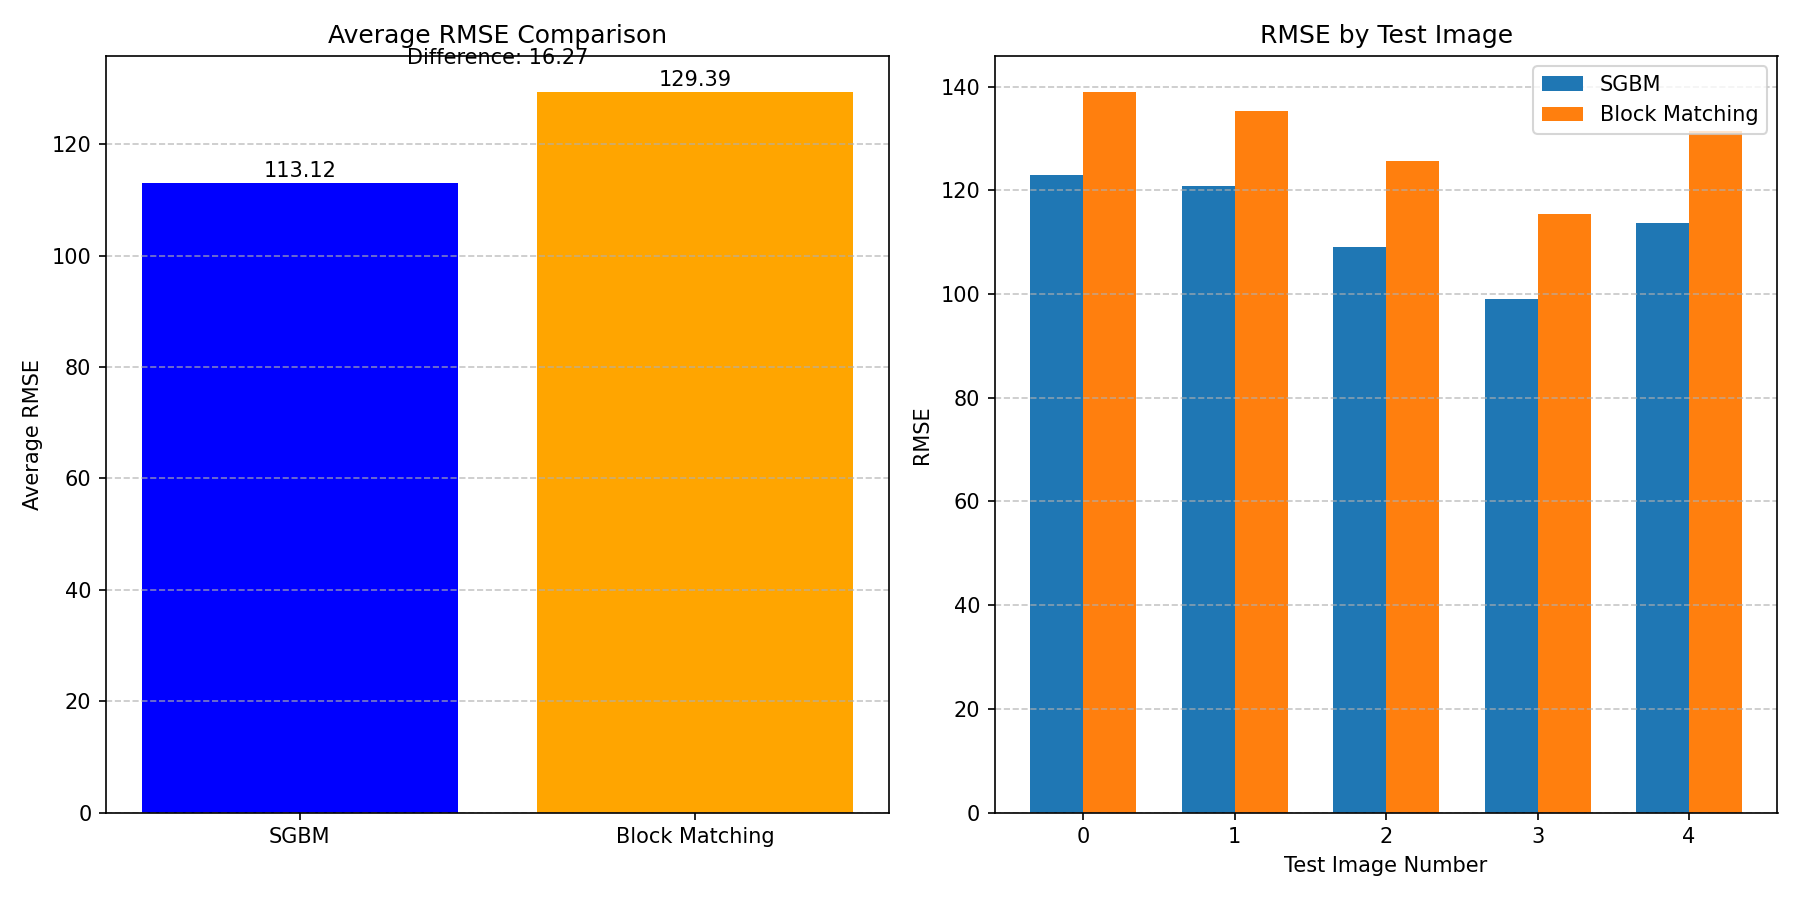


Block Matching Results Summary:
Block Matching Average RMSE: 129.3946
SGBM Average RMSE (for comparison): 113.1234
Difference: 16.2712

Conclusion: SGBM performed better for low-light stereo matching.

Block Matching RMSE for Each Test Image:
Image     Block Matching RMSE 
------------------------------
0         138.9652            
1         135.2612            
2         125.7588            
3         115.4722            
4         131.5156            


In [6]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

print("BLOCK MATCHING RESULTS")
print("=" * 50)

# Paths
results_dir = "results"
bm_output_dir = os.path.join(results_dir, "block_matching")
main_results_path = os.path.join(results_dir, "results.txt")

# Check if results exist
if os.path.exists(main_results_path) and os.path.exists(bm_output_dir):
    with open(main_results_path, "r") as file:
        main_results_content = file.read()
    
    bm_avg_rmse_match = re.search(r'Block Matching Average RMSE: (\d+\.\d+)', main_results_content)
    sgbm_avg_rmse_match = re.search(r'Average RMSE on test set: (\d+\.\d+)', main_results_content)
    test_rmse_matches = re.findall(r'test_(\d+): RMSE = (\d+\.\d+)', main_results_content)
    
    if bm_avg_rmse_match and sgbm_avg_rmse_match:
        bm_avg_rmse = float(bm_avg_rmse_match.group(1))
        sgbm_avg_rmse = float(sgbm_avg_rmse_match.group(1))
        test_nums = sorted([int(m[0]) for m in test_rmse_matches])
        sgbm_rmses = {int(num): float(rmse) for num, rmse in test_rmse_matches}
        
        bm_rmses = {}
        bm_results_file = os.path.join(bm_output_dir, "bm_results.txt")
        if os.path.exists(bm_results_file):
            with open(bm_results_file, "r") as file:
                bm_results_content = file.read()
            bm_test_rmse_matches = re.findall(r'test_(\d+): RMSE = (\d+\.\d+)', bm_results_content)
            for num, rmse in bm_test_rmse_matches:
                bm_rmses[int(num)] = float(rmse)

        # Summary plot
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        methods = ['SGBM', 'Block Matching']
        avg_rmses = [sgbm_avg_rmse, bm_avg_rmse]
        bars = plt.bar(methods, avg_rmses, color=['blue', 'orange'])
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.2f}', ha='center')
        plt.ylabel('Average RMSE')
        plt.title('Average RMSE Comparison')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        diff = abs(avg_rmses[0] - avg_rmses[1])
        plt.text(0.5, max(avg_rmses) + 5, f'Difference: {diff:.2f}', ha='center')

        # Per-image RMSE plot
        plt.subplot(1, 2, 2)
        x = np.arange(len(test_nums))
        width = 0.35
        sgbm_values = [sgbm_rmses[i] for i in test_nums]
        bm_values = [bm_rmses.get(i, np.nan) for i in test_nums]
        plt.bar(x - width/2, sgbm_values, width, label='SGBM')
        plt.bar(x + width/2, bm_values, width, label='Block Matching')
        plt.xlabel('Test Image Number')
        plt.ylabel('RMSE')
        plt.title('RMSE by Test Image')
        plt.xticks(x, test_nums)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        summary_path = os.path.join(results_dir, "block_matching_summary.png")
        plt.savefig(summary_path, dpi=150)
        plt.close()

        # Display summary plot
        print("Block Matching Summary:")
        display(Image(filename=summary_path, width=1000))

        # Print stats
        print(f"\nBlock Matching Results Summary:")
        print(f"Block Matching Average RMSE: {bm_avg_rmse:.4f}")
        print(f"SGBM Average RMSE (for comparison): {sgbm_avg_rmse:.4f}")
        print(f"Difference: {diff:.4f}")
        winner = "SGBM" if sgbm_avg_rmse < bm_avg_rmse else "Block Matching"
        print(f"\nConclusion: {winner} performed better for low-light stereo matching.")

        print("\nBlock Matching RMSE for Each Test Image:")
        print(f"{'Image':<10}{'Block Matching RMSE':<20}")
        print("-" * 30)
        for test_num in test_nums:
            if test_num in bm_rmses:
                print(f"{test_num:<10}{bm_rmses[test_num]:<20.4f}")
    else:
        print("Could not extract RMSE values from results file.")
else:
    print("Block Matching results not found. Run the full evaluation first.")



Block Matching Results for All Test Images:


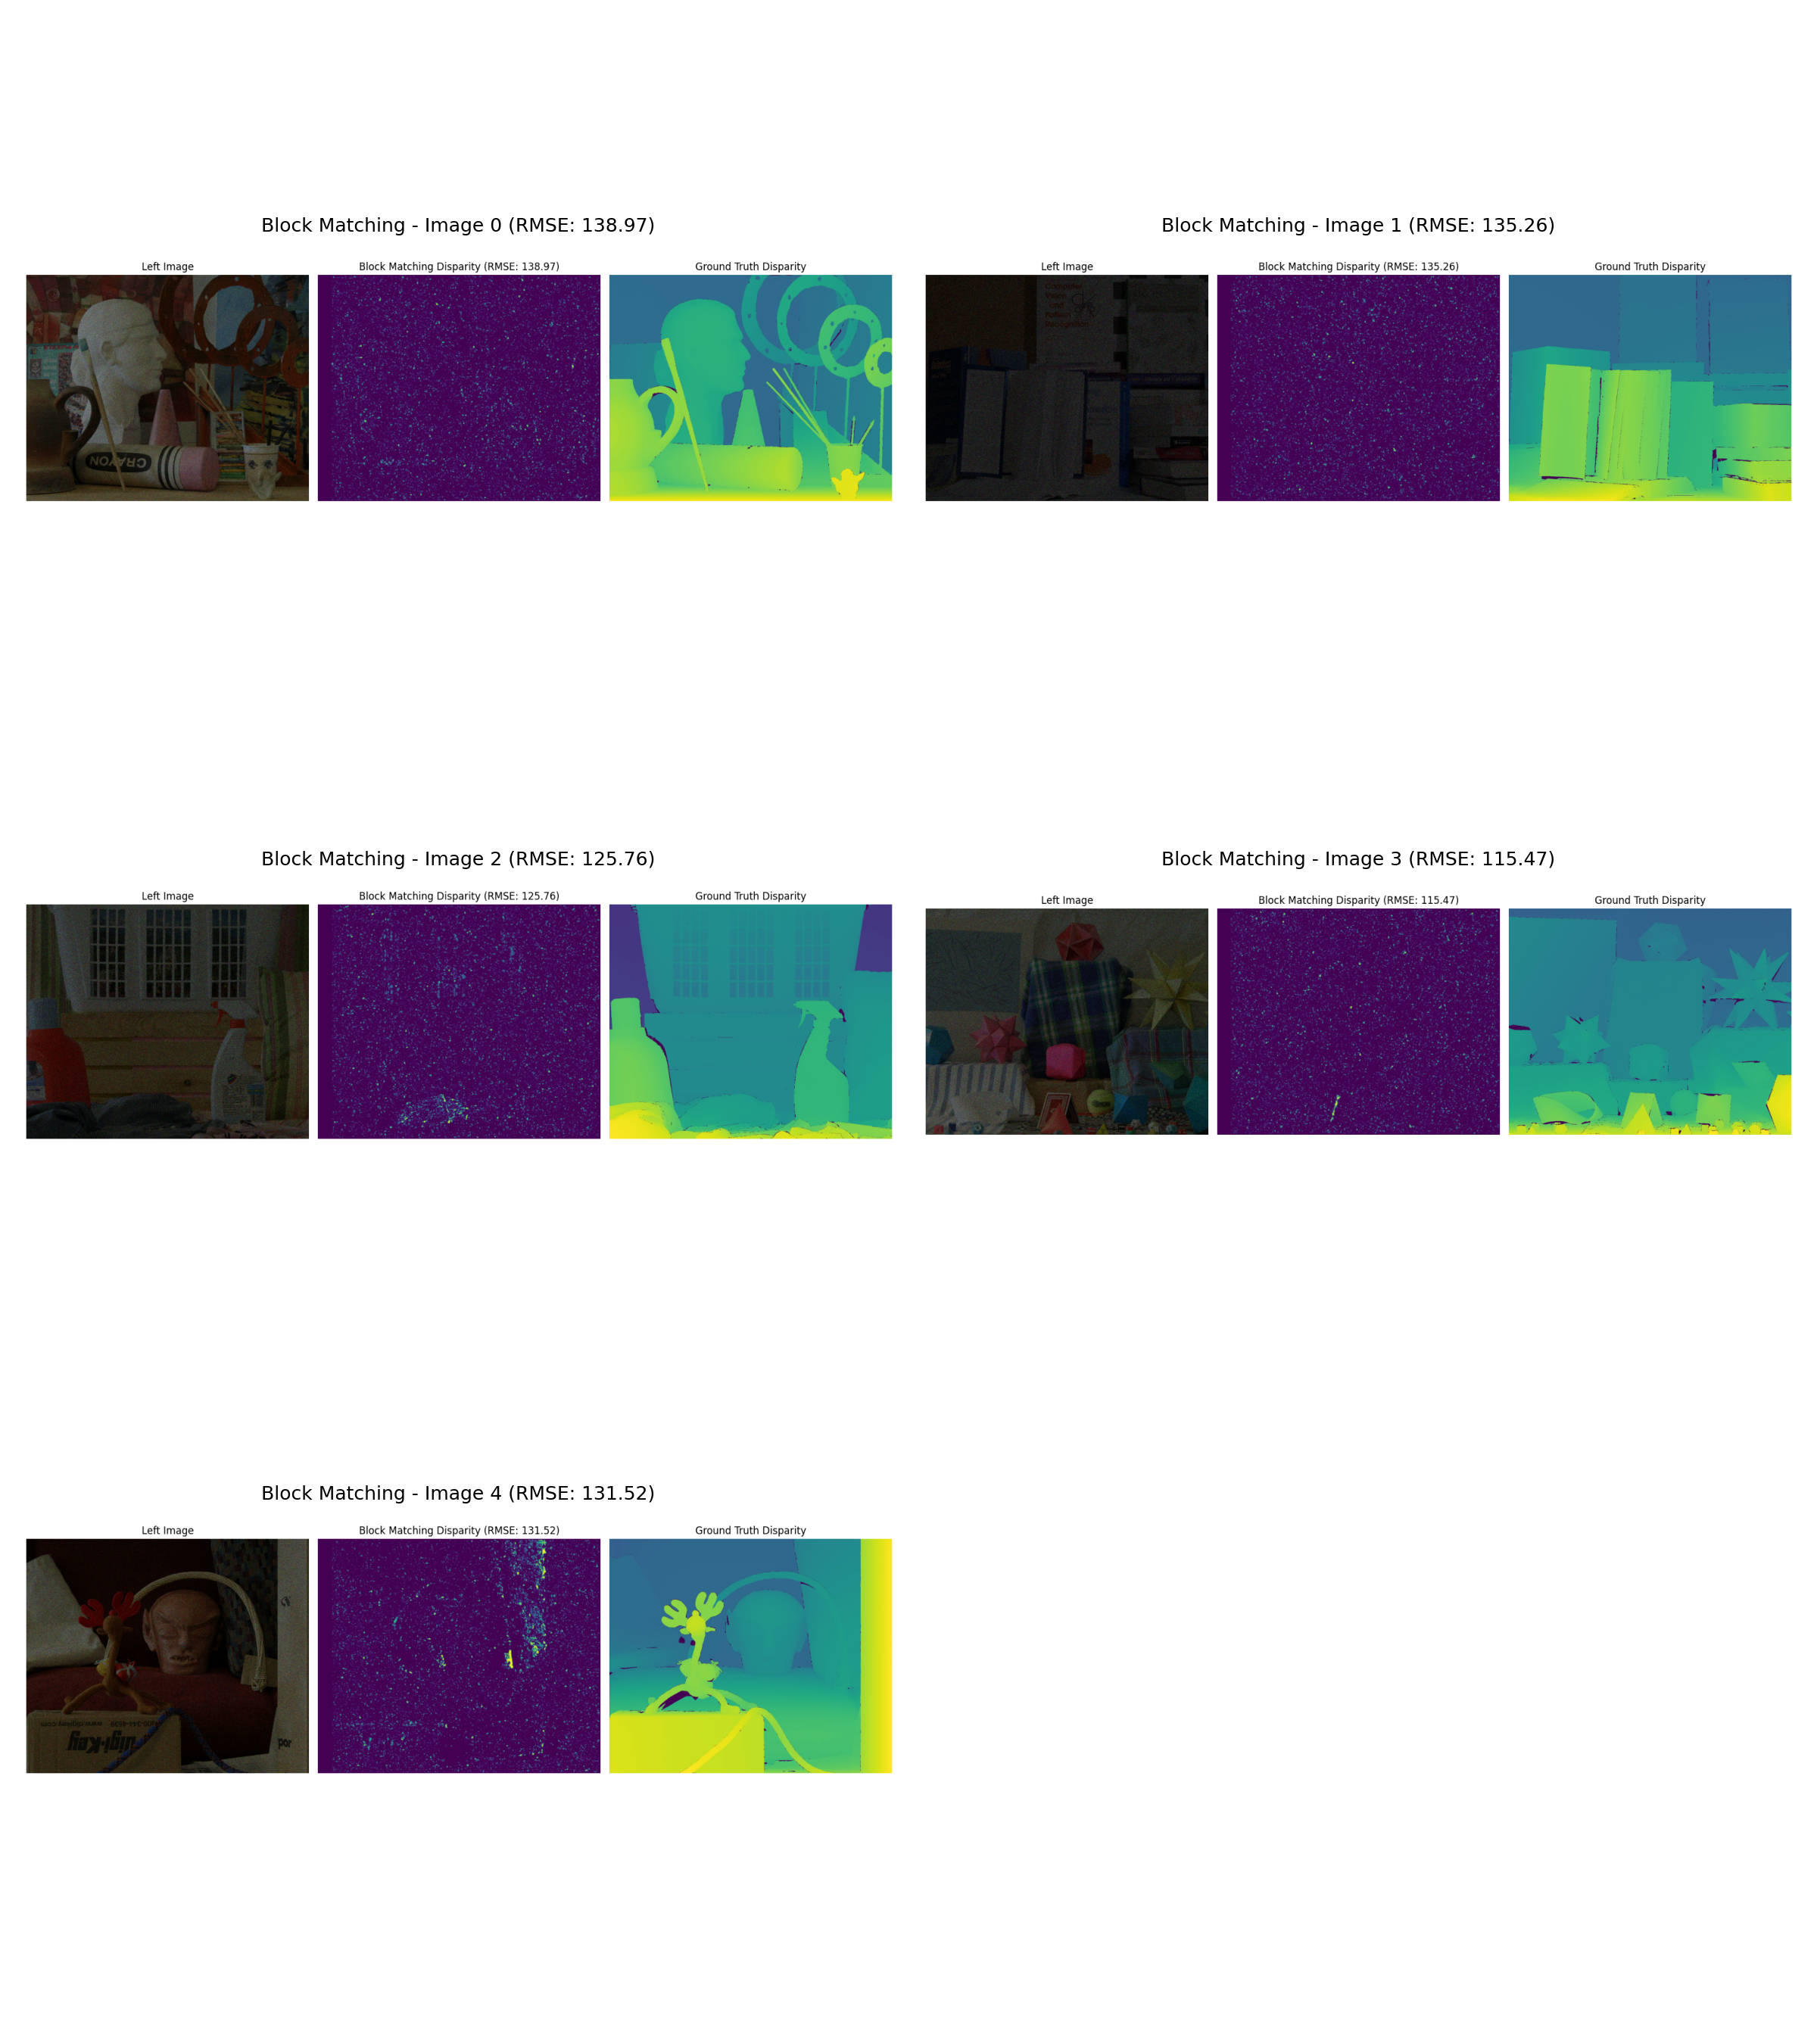

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

results_dir = "results"
bm_output_dir = os.path.join(results_dir, "block_matching")
bm_results_file = os.path.join(bm_output_dir, "bm_results.txt")

if os.path.exists(bm_results_file):
    with open(bm_results_file, "r") as file:
        content = file.read()
    test_rmse_matches = re.findall(r'test_(\d+): RMSE = (\d+\.\d+)', content)
    test_nums = sorted([int(m[0]) for m in test_rmse_matches])
    bm_rmses = {int(num): float(rmse) for num, rmse in test_rmse_matches}

    # Calculate layout
    num_tests = len(test_nums)
    rows = int(np.ceil(num_tests / 2))
    plt.figure(figsize=(16, 6 * rows))

    for i, test_num in enumerate(test_nums):
        plt.subplot(rows, 2, i + 1)
        bm_image_path = os.path.join(bm_output_dir, f"bm_result_{test_num}.png")
        if os.path.exists(bm_image_path):
            img = plt.imread(bm_image_path)
            plt.imshow(img)
            plt.title(f'Block Matching - Image {test_num} (RMSE: {bm_rmses[test_num]:.2f})')
            plt.axis('off')

    plt.tight_layout()
    all_results_path = os.path.join(results_dir, "block_matching_results.png")
    plt.savefig(all_results_path, dpi=150)
    plt.close()

    # Display result image
    print("\nBlock Matching Results for All Test Images:")
    display(Image(filename=all_results_path, width=1000))
else:
    print("BM results file not found. Cannot display test image results.")


SGBM RESULTS


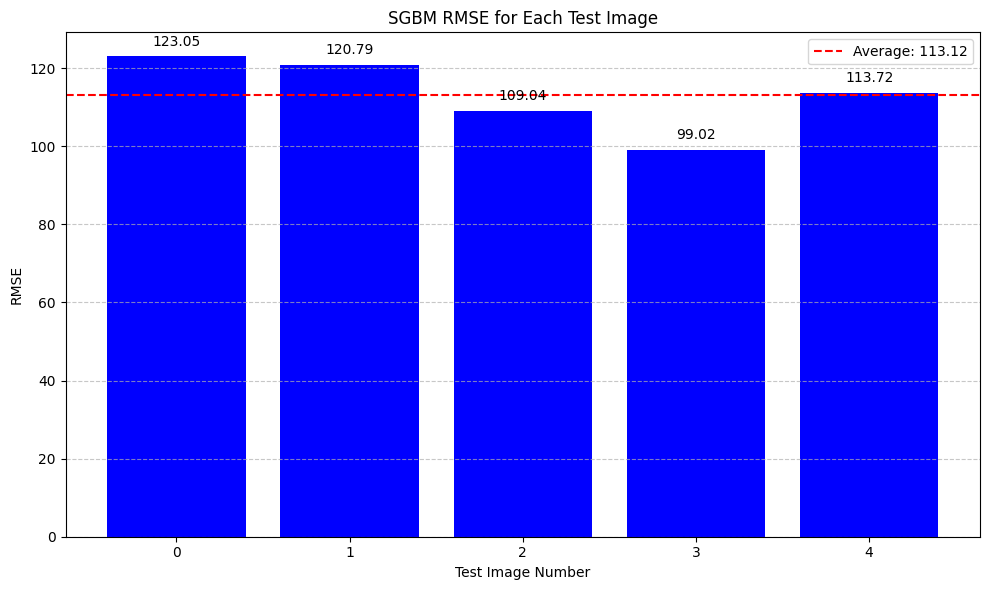


SGBM Results Summary:
SGBM Average RMSE: 113.1234

Parameters used:
  block_size: 11
  denoise_strength: 10
  brightness_factor: 2.0

SGBM RMSE for Each Test Image:
Image     SGBM RMSE      
-------------------------
0         123.0540       
1         120.7866       
2         109.0395       
3         99.0186        
4         113.7185       


In [3]:
from IPython.display import Image, display
import os
import re
import matplotlib.pyplot as plt
import numpy as np

print("SGBM RESULTS")
print("=" * 50)

# Read results file
results_dir = "results"
results_file_path = os.path.join(results_dir, "results.txt")

if os.path.exists(results_file_path):
    with open(results_file_path, "r") as file:
        results_content = file.read()
    
    # Extract SGBM RMSE values and parameters
    sgbm_avg_rmse_match = re.search(r'Average RMSE on test set: (\d+\.\d+)', results_content)
    params_match = re.search(r'Best parameters: ({.*})', results_content)
    test_rmse_matches = re.findall(r'test_(\d+): RMSE = (\d+\.\d+)', results_content)
    
    if sgbm_avg_rmse_match:
        # Get SGBM RMSE values
        sgbm_avg_rmse = float(sgbm_avg_rmse_match.group(1))
        test_nums = sorted([int(m[0]) for m in test_rmse_matches])
        sgbm_rmses = {}
        for num, rmse in test_rmse_matches:
            sgbm_rmses[int(num)] = float(rmse)
        
        # Create bar chart of SGBM RMSE values
        plt.figure(figsize=(10, 6))
        bars = plt.bar(test_nums, [sgbm_rmses[i] for i in test_nums], color='blue')
        plt.xlabel('Test Image Number')
        plt.ylabel('RMSE')
        plt.title('SGBM RMSE for Each Test Image')
        plt.xticks(test_nums)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{height:.2f}', ha='center', va='bottom')
        
        # Add average line
        plt.axhline(y=sgbm_avg_rmse, color='r', linestyle='--', 
                   label=f'Average: {sgbm_avg_rmse:.2f}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print numerical summary
        print(f"\nSGBM Results Summary:")
        print(f"SGBM Average RMSE: {sgbm_avg_rmse:.4f}")
        
        # Display parameters used
        if params_match:
            print("\nParameters used:")
            import ast
            params = ast.literal_eval(params_match.group(1))
            for key, value in params.items():
                print(f"  {key}: {value}")
        
        # Display per-image SGBM RMSE table
        print("\nSGBM RMSE for Each Test Image:")
        print(f"{'Image':<10}{'SGBM RMSE':<15}")
        print("-" * 25)
        for test_num in test_nums:
            sgbm_val = sgbm_rmses[test_num]
            print(f"{test_num:<10}{sgbm_val:<15.4f}")
    else:
        print("Could not extract SGBM RMSE values from results file.")
else:
    print("Results file not found. Run the algorithm first.")

Displaying comparison of all test results:


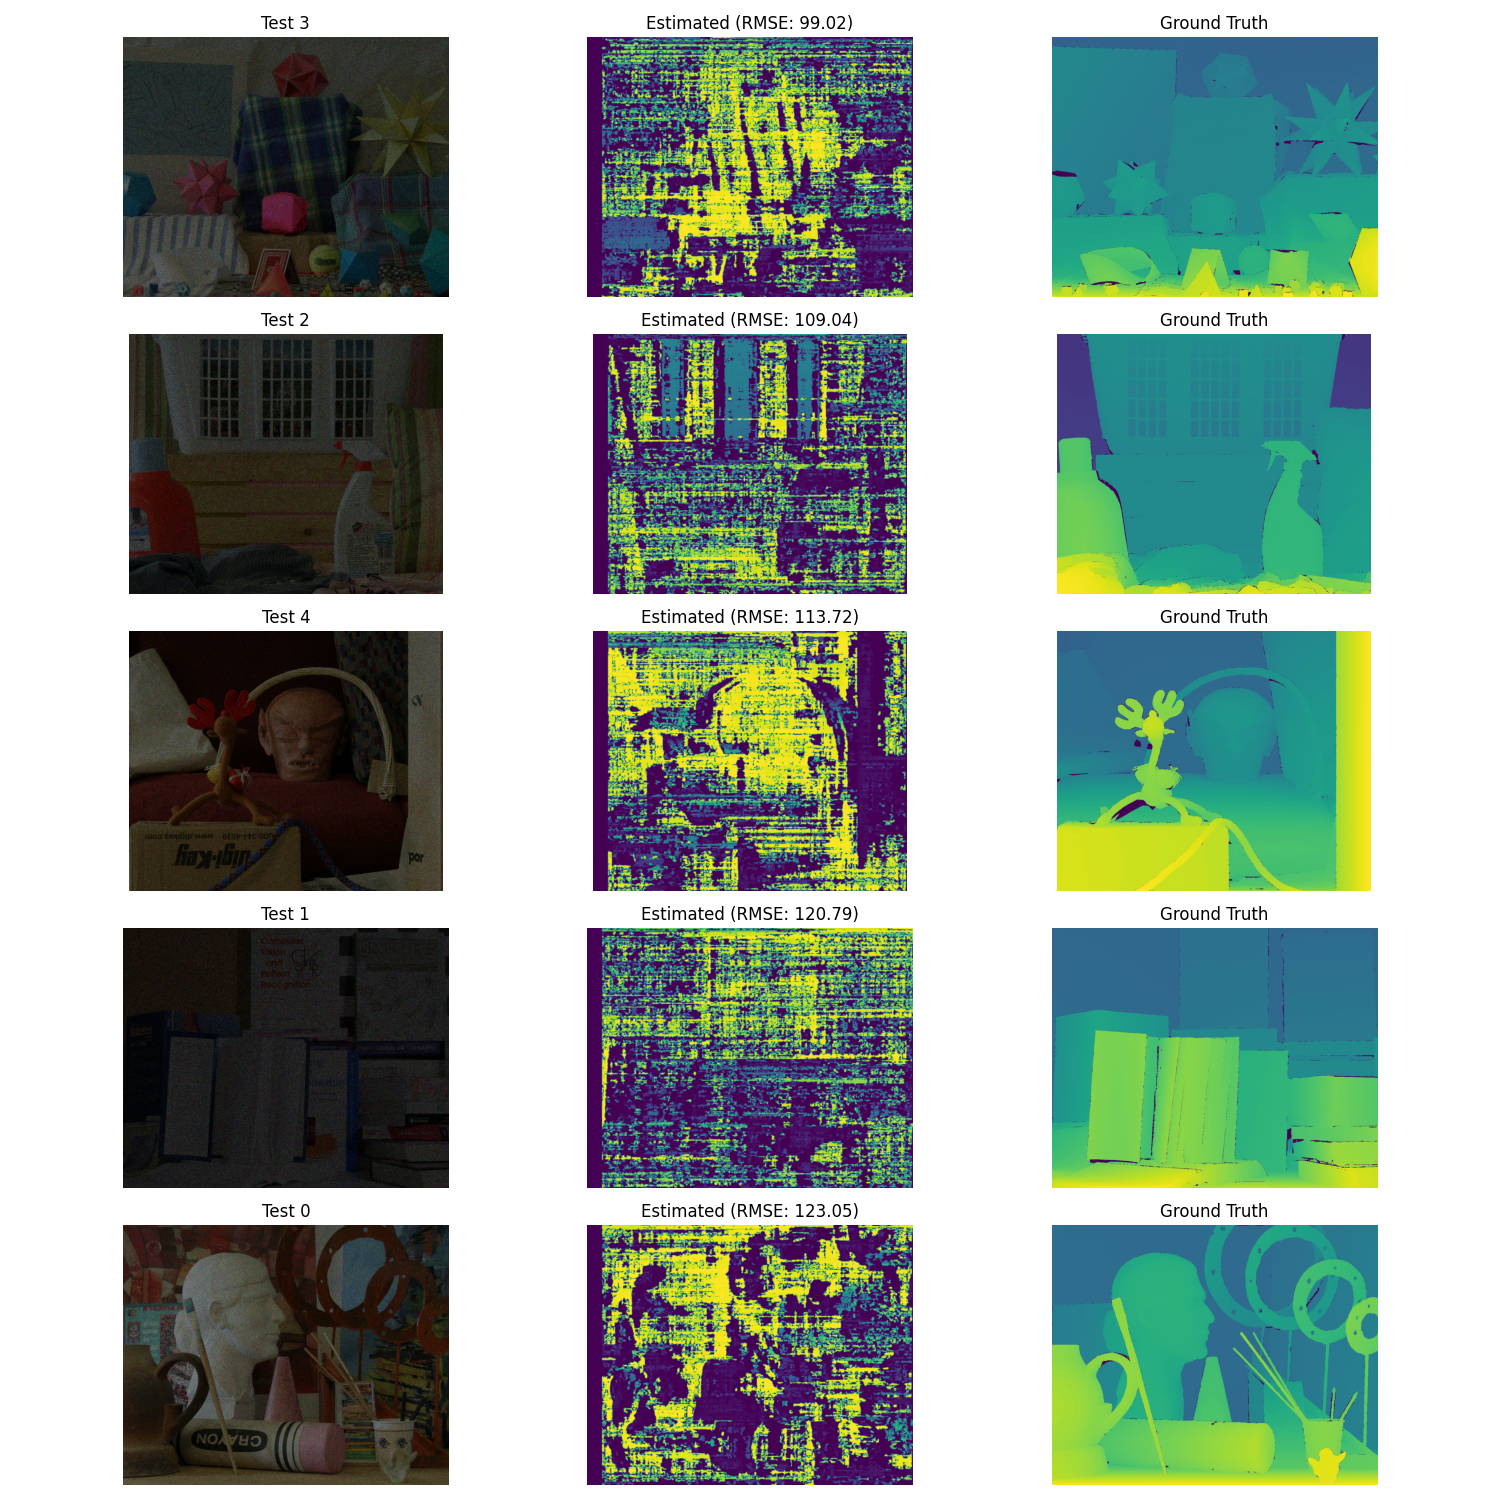

In [4]:
from IPython.display import Image, display
import os

results_image_path = os.path.join("results", "all_results.png")
if os.path.exists(results_image_path):
    print("Displaying comparison of all test results:")
    display(Image(filename=results_image_path, width=900))
else:
    print("Image not found. If you've run the algorithm, check if the file exists at:", results_image_path)